# Занятие 13. Проект построения модели машинного обучения для регрессии

### 1. Problem Definition, Loading the libraries and the dataset

In [7]:
# Load libraries
import os
import numpy
from numpy import arange
from matplotlib import pyplot
from pandas import read_csv
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [8]:
dataset = read_csv('ready_data.csv',index_col=0)

In [9]:
dataset = dataset[['price_per_square', 'squares', 'free', 'current_floor', 'max_floor',
       'latitude', 'longitude','Nevskii prospekt','parkings_1km']]

In [10]:
dataset = dataset[dataset['price_per_square']>= 30000.0]
dataset = dataset[dataset['price_per_square']<=450000.0]

Q1 = dataset['price_per_square'].quantile(0.05)
Q3 = dataset['price_per_square'].quantile(0.95)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dataset = dataset[(dataset['price_per_square'] >= lower_bound) & (dataset['price_per_square'] <= upper_bound)]

In [11]:
dataset = dataset[dataset['squares']<=200]
dataset = dataset[['price_per_square', 'squares', 'max_floor',
       'latitude', 'longitude','Nevskii prospekt','parkings_1km']]
data = dataset[dataset['Nevskii prospekt']<=30]

### 2. Analyze Data

#### Descriptive statistics

In [12]:
# shape
print(dataset.shape)

(814, 7)


In [13]:
# types
print(dataset.dtypes)

price_per_square    float64
squares             float64
max_floor             int64
latitude            float64
longitude           float64
Nevskii prospekt    float64
parkings_1km        float64
dtype: object


In [14]:
# head
dataset.head()

,price_per_square,squares,max_floor,latitude,longitude,Nevskii prospekt,parkings_1km
0,311480.0,131.63,2,30.082621,59.724677,28.29,47.0
1,254997.0,145.10,5,30.316138,59.911854,1.73,55.0
2,353742.0,73.50,7,30.301127,59.912368,3.13,55.0
3,190000.0,33.90,9,30.449978,59.956836,13.70,15.0
4,166667.0,89.40,5,30.325543,59.926372,0.50,26.0


In [15]:
round(dataset.describe())

,price_per_square,squares,max_floor,latitude,longitude,Nevskii prospekt,parkings_1km
count,814.0,814.0,814.0,814.0,814.0,814.0,814.0
mean,248978.0,95.0,10.0,30.0,60.0,9.0,44.0
std,91615.0,47.0,8.0,0.0,0.0,7.0,22.0
min,33750.0,4.0,1.0,30.0,60.0,0.0,0.0
25%,179470.0,61.0,3.0,30.0,60.0,3.0,27.0
50%,248954.0,87.0,7.0,30.0,60.0,7.0,42.0
75%,319170.0,128.0,14.0,30.0,60.0,11.0,58.0
max,450000.0,200.0,28.0,31.0,60.0,62.0,120.0


#### Data Visualizations

##### Unimodal Data Visualizations

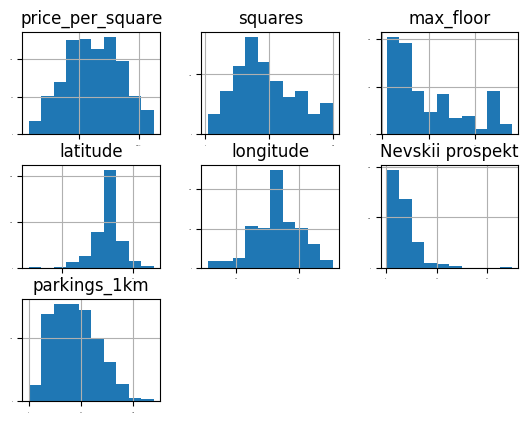

In [16]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1)
pyplot.show()

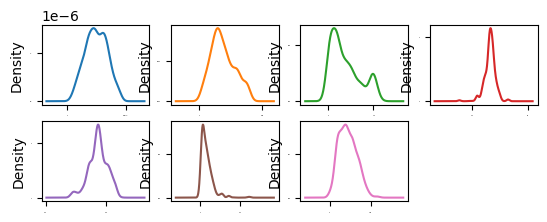

In [29]:
# density
dataset.plot(kind='density', subplots=True, layout=(4,4), sharex=False, legend=False,
fontsize=1)
pyplot.show()

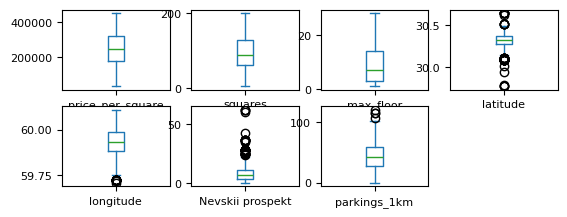

In [30]:
# box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False,
fontsize=8)
pyplot.show()

##### Multimodal Data Visualizations

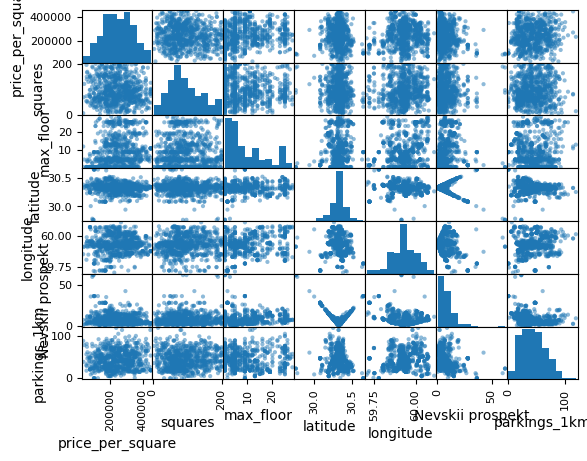

In [31]:
# scatter plot matrix
scatter_matrix(dataset)
pyplot.show()

In [33]:
names = ['price_per_square', 'squares', 'max_floor',
       'latitude', 'longitude','Nevskii prospekt','parkings_1km']

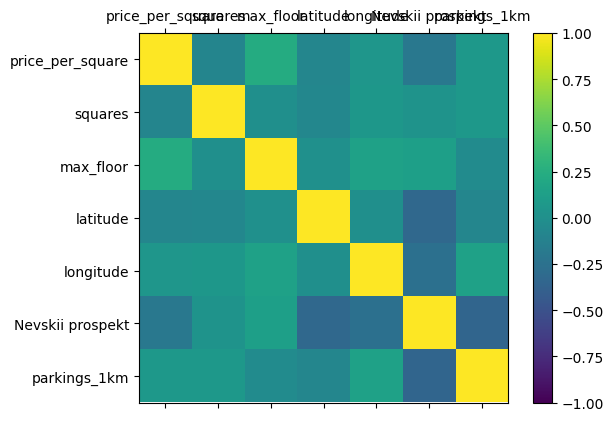

In [35]:
# correlation matrix
fig = pyplot.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(dataset.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cax)
ticks = numpy.arange(0,7,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names)
ax.set_yticklabels(names)
pyplot.show()

### 3. Validation Dataset

In [37]:
# Split-out validation dataset
array = dataset.values
X = array[:,1:6]
Y = array[:,0]
validation_size = 0.50
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y,
test_size=validation_size, random_state=seed)

### 4. Evaluate Algorithms: Baseline

In [51]:
# Test options and evaluation metric
num_folds = 2
seed = 7
scoring = 'neg_mean_absolute_percentage_error'

In [52]:
# Spot-Check Algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.398553 (0.005458)
LASSO: -0.398556 (0.005455)
EN: -0.410749 (0.008758)
KNN: -0.436844 (0.008095)
CART: -0.416394 (0.021429)
SVR: -0.441846 (0.009063)


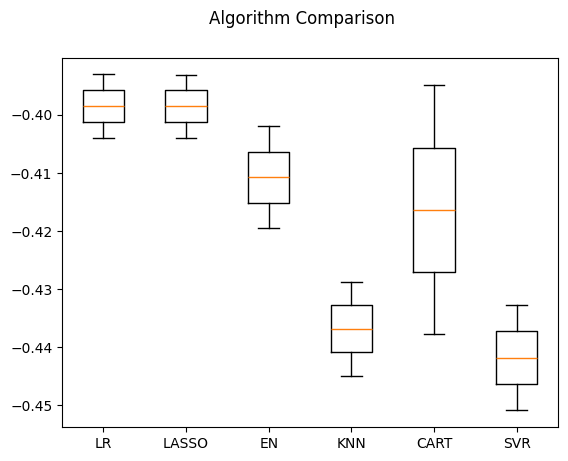

In [53]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 5. Evaluate Algorithms: Standardize Data

In [54]:
# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',
LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',
Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',
ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',
KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',
DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -0.398553 (0.005458)
ScaledLASSO: -0.398555 (0.005456)
ScaledEN: -0.418959 (0.000283)
ScaledKNN: -0.388226 (0.016507)
ScaledCART: -0.431927 (0.025833)
ScaledSVR: -0.441843 (0.009063)


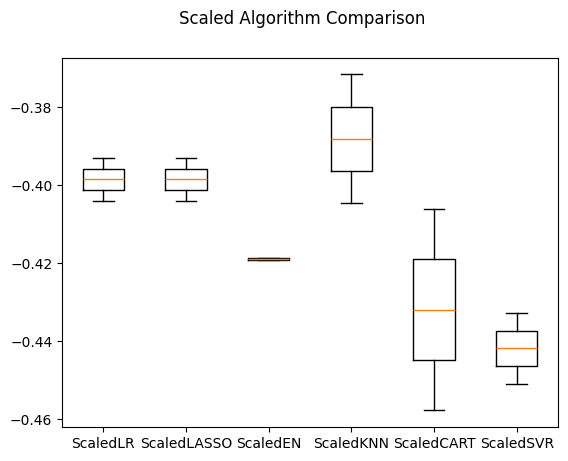

In [55]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

### 6. Algorithm Tuning

In [56]:
# KNN Algorithm tuning
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = numpy.array([1,3,5,7,9,11,13,15,17,19,21])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.384321 using {'n_neighbors': 1}
-0.384321 (0.014597) with: {'n_neighbors': 1}
-0.386278 (0.001144) with: {'n_neighbors': 3}
-0.390344 (0.013816) with: {'n_neighbors': 5}
-0.397175 (0.001407) with: {'n_neighbors': 7}
-0.404360 (0.001219) with: {'n_neighbors': 9}
-0.406133 (0.002523) with: {'n_neighbors': 11}
-0.406764 (0.006529) with: {'n_neighbors': 13}
-0.409654 (0.002349) with: {'n_neighbors': 15}
-0.413504 (0.000154) with: {'n_neighbors': 17}
-0.417502 (0.000883) with: {'n_neighbors': 19}
-0.418375 (0.001349) with: {'n_neighbors': 21}


### 7. Ensemble Methods

In [57]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB',
AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM',
GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',
RandomForestRegressor(n_estimators=10))])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',
ExtraTreesRegressor(n_estimators=10))])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: -0.402132 (0.008127)
ScaledGBM: -0.359843 (0.009404)
ScaledRF: -0.346259 (0.027344)
ScaledET: -0.334864 (0.001649)


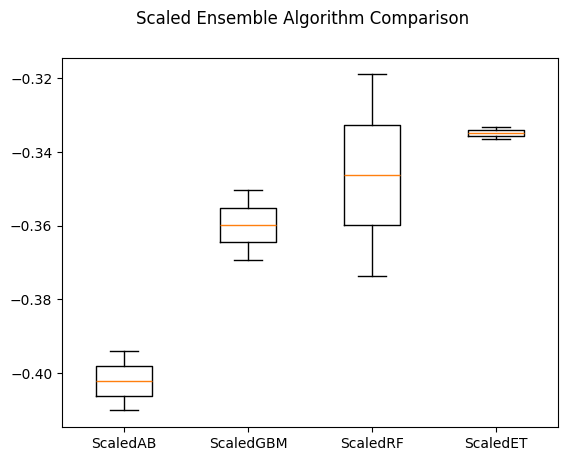

In [58]:
# Compare Algorithms
fig = pyplot.figure()
fig.suptitle('Scaled Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [60]:
# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=numpy.array([50,100,150,200,250,300,350,400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

In [61]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.355785 using {'n_estimators': 250}
-0.365453 (0.005614) with: {'n_estimators': 50}
-0.360612 (0.007529) with: {'n_estimators': 100}
-0.359113 (0.007678) with: {'n_estimators': 150}
-0.356714 (0.006247) with: {'n_estimators': 200}
-0.355785 (0.007321) with: {'n_estimators': 250}
-0.355793 (0.006148) with: {'n_estimators': 300}
-0.356149 (0.005869) with: {'n_estimators': 350}
-0.357252 (0.004809) with: {'n_estimators': 400}


### 8. Finalize Model

In [67]:
# prepare the model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingRegressor(random_state=seed, n_estimators=250)
model.fit(rescaledX, Y_train)

GradientBoostingRegressor(n_estimators=250, random_state=7)

In [68]:
# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
print(mean_squared_error(Y_validation, predictions))
print(mean_absolute_error(Y_validation, predictions))
print(mean_absolute_percentage_error(Y_validation, predictions))

5500171908.998586
55237.08542838603
0.2958718529603338


In [70]:
dataset.to_csv('gotov_data.csv', encoding='utf-8')